# Prototipo de MoDem especializado en la técnica LoRa para la transmisión y recepción en SDRs (V 0.1.0)



## Implementación del MoDem LoRa


La modulación LoRa se podría catalogar como una **manera sistemática de encapsular símbolos** a través de distintas configuraciones en la evolución lineal de la frecuencia para una señal chirp, actuante de portadora.



### Definición, implementación e implicancias de los parámetros

Para poder llevar a cabo la implementación del MoDem, es necesario tener en cuenta aquellos parámetros del sistema de comunicación que se deban mantener a lo largo de cada transmisión. Así como en AM uno sintoniza a una frecuencia específica para estar en sintonía el transmisor con el receptor, en LoRa deberemos manifestar estos parámetros *externos* (omitiendo el Coding Rate por ahora):

- Bandwidth (Ancho de Banda): El ancho de banda especificado para una transimisión LoRa deberá ser especificado ya que definirá los límites inferiores y superiores en los que la frecuencia presentará esta variación. Es decir, si establecemos un ancho de banda de por ejemplo $Bw = 125$ kHz, se tendrá entonces una evolución de la frecuencia siempre entre esos valores. 
  
- Spreading Factor (Factor de expansión): Este parámetro engloba dos responsabilidades: Representar la cantidad de bits que se podrán transmitir en un símbolo y que tanto se esparcirá en el tiempo (es decir, su duración) la transmisión del símbolo.

- Resolución entre chips: Para esta implementación, se dará la posibilidad de *"tender a lo analógico* a través del uso de un parámetro de resolución, que permitirá expandir los puntos renderizados (más allá de los mínimos). Se representará en el álgebra como $R_B$ donde la $R$ se refiere a "resolución" y la $B$ se refiere al término anglosajón "in-between" de "entre".
  

Además, podemos catalogar a los parámetros *internos* como aquellos que se deducen directamente a partir de los parámetros internos antes mencionados, así poder reutilizarlos como variables una vez se realice el código:

- Chips y Número de Chips: El chip representa la unidad fundamental de información, resultante de la expansión realizada por el $SF$. Es equivalente (aunque no son sinónimos) con la cantidad de combinaciones posibles para transmitir un símbolo, a saber: $N_{C}= 2^{SF}$. Es decir, que el chip es item de menor expresión en la secuencia de evolución de frecuencia a lo largo del tiempo. (Es decir, la mínima muestra que mantiene el concepto de la técnica LoRa)

- Samples Per Symbol (Muestras por símbolo): Representa cuantos puntos se renderizarán en la función discreta. Para ello, podremos calcularla como: $SPS = N_{C} \cdot R_B$. Con que las muestras por símbolo equivalgan al número de chips, ya se tiene una representación suficiente de cada chip. Sin embargo, se puede multiplicar esto por un factor de resolución para aumentar el número de muestras.

- Symbol Duration (duración por símbolo): Representa cuanto tiempo le tomará a nuestro chirp barrer todo el ancho de banda. Este se calcula como: $T_S= \frac{N_{C}}{Bw}$
- Frequency Slope (pendiente de frecuencia): Representa la tasa de cambio de la evolución lineal de nuestra frecuencia. Se calcula como cualquier otra pendiente, tomándonos la libertad de asumir como 0 el símbolo transmitido, para evitar introducir la discontinuidad, aprovechando de que la pendiente será constnate incluso en presencia de discontinuidades:
  
    $m_f = \frac{\Delta Y}{\delta X} =  \frac{(Bw - 0)}{\frac{N_{C}}{Bw}-0} = \frac{Bw^2}{N_c}$

### Evolución de la Frecuencia instantánea a través del tiempo

Para poder determinar la evolución lineal de la frecuencia instantánea a lo largo del tiempo en base a los símbolos a enviar, se utilizará un simple algoritmo que se sostiene de la duración de símbolo, la pendiente y la ordenada al origen de cada símbolo para obtener la evolución de la frecuencia.

Este procedimiento se hará mediante el método `generate_frequency_evolution_across_time`, el cual funciona de la siguiente manera:
- Se inicializan las listas que contendrán la evolución del tiempo y de la evolución de la frecuencia. Además se inicializará también un factor de offset para poder concatenar los símbolos sin mayor dificultad.
- Se itera para cada símbolo obtenido, alli:
  - Se establece la pendiente (la misma para un upchirp o cualquier símbolo, excepto para los downchirps)
  - Se establece la ordenada al origen, siendo la frecuencia inicial del futuro chirp (se calcula como el símbolo ponderado por el ancho de banda).
  - Se le asigna mediante un segundo loop, el valor de frecuencia instantánea que tendrá nuestra señal a lo largo del tiempo. Teniendo en cuenta de no sobrepasar el limite superior
- Por último, se devuelve el vector tiempo con los offsets de continuidad de símbolo, el vector tiempo con reinicio (vendrá útil para la siguiente sección y evitar más cálculo) y la evolución de la frecuencia que tendrá el chirp.
  

### Generación del chirp


Para generar el chirp como tal, simplemente se agregó el método `generate_chirp_from_frequency_evolution`, el cual funciona de la siguiente manera:
- Recibe una línea de tiempo que debe no tener offsets de continuidad (para que se resetee el paso del tiempo en cada símbolo) y su correspondiente evolución de la frecuencia instantánea.
- Para cada muestra, se calcula el valor de magnitud física que tendrá la señal (su eje y) de la siguiente forma:
  
    $s[n] = \frac{1}{\sqrt{2^{SF}}}\cdot e^{j2\pi f_i[n] n}$
- Finalmente, se devuelve la señal en su totalidad.

### Modulando símbolos y Paquetes

Para recopilar estos métodos presentados, se desarrolló el método `modulate_symbols` y `modulate_implicit_package`.
Estos simplemente encadenan los métodos de generación de frecuencias instantaneas y de chirp, para terminar devolviendo la evolución del tiempo, de la señal y de la frecuencia si es que se desea (booleano parametrizado).

`modulate_implicit_package` funciona igual, con la diferencia de que se agrega un preámbulo consistente de $n$ + 2 upchirps (simplemente el envío del 0) con 2 downchirps y un downchirp más acortado a un cuarto de ciclo antepuestos al mensaje. Evidentemente el sumando $n$ está parametrizado, y por defecto suele ser el número 8.

In [84]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt

class LoraReservedArtifacts(Enum):
    FULL_UPCHIRP = 0
    FULL_DOWNCHIRP = 1
    QUARTER_DOWNCHIRP = 2


class LoraModulator:
    def __init__(self, spreading_factor, bandwidth, resolution_between_chips):
        # LoRa technique external parameters
        self.__spreading_factor = spreading_factor
        self.__bandwidth = bandwidth
        self.__resolution_between_chips = resolution_between_chips

        # Lora technique internal parameters
        self.__chips_number = 2 ** spreading_factor
        self.__symbol_duration = self.__chips_number / bandwidth
        self.__samples_per_symbol = int(self.__chips_number * resolution_between_chips)
        self.__sampling_period = self.__symbol_duration / self.__samples_per_symbol
        self.__frequency_slope = (bandwidth ** 2) / self.__chips_number


    # temp
    def validate(self):
        assert self.__spreading_factor in [7, 8, 9, 10, 11, 12]
        assert self.__bandwidth in [125, 250, 500]
        assert self.resolution_between_chips in [4, 8]

    def generate_frequency_evolution_across_time(self, symbols, return_only_offset_time_axis= True):

        frequency_evolution = []
        time_axis = []
        time_axis_without_offset = []
        current_offset = 0
        
        for symbol in symbols:
            current_slope = self.__frequency_slope

            
            
            symbol_time_axis = np.linspace(current_offset, current_offset + self.__symbol_duration, self.__samples_per_symbol)
            # print(current_offset+ self.__symbol_duration, symbol_time_axis[-1])  
            if symbol == LoraReservedArtifacts.FULL_UPCHIRP:
                symbol = 0

            elif symbol == LoraReservedArtifacts.FULL_DOWNCHIRP:
                symbol = 2**self.__spreading_factor - 1
                current_slope = - current_slope
            
            elif symbol == LoraReservedArtifacts.QUARTER_DOWNCHIRP:
                symbol = 2**self.__spreading_factor - 1
                current_slope = - current_slope
                quarter_cycle_max_index = int(len(symbol_time_axis) // 4 + 1)
                symbol_time_axis = symbol_time_axis[:quarter_cycle_max_index]
        
            # Not using chips number due to theorical reasons (equivalent in value, not in meaning)
            y_intercept = symbol * ( self.__bandwidth / (2**self.__spreading_factor-1) )
   

            for i in range(len(symbol_time_axis)):
                instantaneous_frequency = y_intercept + current_slope * (symbol_time_axis[i] - current_offset)

                if instantaneous_frequency > self.__bandwidth:
                    # Not necesarry to take into account multiples of bandwidth, as the duration of the chirp is limited 
                    # (i think)
                    instantaneous_frequency -= self.__bandwidth


                frequency_evolution.append(instantaneous_frequency)
            
            time_axis.extend(symbol_time_axis)
            symbol_time_axis_without_offset = symbol_time_axis - current_offset
            time_axis_without_offset.extend(symbol_time_axis_without_offset)
            
            time_stop = symbol_time_axis[-1] + self.__sampling_period
            current_offset = time_stop
            
        if return_only_offset_time_axis:
            return time_axis, frequency_evolution
        if not return_only_offset_time_axis:
            return time_axis, time_axis_without_offset,frequency_evolution
        return time_axis, frequency_evolution
    
    def generate_chirp_from_frequency_evolution(self, time_axis, frequency_evolution):
        coefficient = 1/np.sqrt(np.sqrt(2**self.__spreading_factor)*self.resolution_between_chips)
        signal = []
        for i in range(len(time_axis)):
            instantaneous_phase = 1j * 2 * np.pi * frequency_evolution[i] * time_axis[i]
            signal_sample = coefficient * np.exp(instantaneous_phase)
            signal.append(signal_sample)
        return signal
        
    def modulate_symbols(self, symbols, also_return_frequency_evolution = False):
        for symbol in symbols:
            if symbol not in range(self.__chips_number) and not isinstance(symbol, LoraReservedArtifacts):
                raise ValueError(f"Symbols have to be of type LoraReservedArtifacts or integers between 0 and {self.__chips_number - 1} for the spreading factor that was configurated.")
        time_axis, no_offset_time_axis, frequency_evolution = self.generate_frequency_evolution_across_time(symbols, False)
        signal = self.generate_chirp_from_frequency_evolution(no_offset_time_axis, frequency_evolution)
        if not also_return_frequency_evolution:
            return time_axis, signal
        return time_axis, signal, frequency_evolution

    
    def modulate_implicit_package(self,preamble_number, payload, also_return_frequency_evolution = False):
        package = []
        for i in range(preamble_number):
            package.append(LoraReservedArtifacts.FULL_UPCHIRP)
        for i in range(2):
            package.append(LoraReservedArtifacts.FULL_UPCHIRP)
        for i in range(2):
            package.append(LoraReservedArtifacts.FULL_DOWNCHIRP)
        package.append(LoraReservedArtifacts.QUARTER_DOWNCHIRP)

        package.extend(payload)
        time_axis, signal, frequency_evolution = self.modulate_symbols(package, True)
        if not also_return_frequency_evolution:
            return time_axis, signal
        return time_axis, signal, frequency_evolution
    
    @property
    def spreading_factor(self):
        return self.__spreading_factor
    @spreading_factor.setter
    def spreading_factor(self, value):
        if value not in [7, 8, 9, 10, 11, 12]:
            raise ValueError("Spreading factor has to be one of the integers: 7, 8, 9, 10, 11 or 12")
        self.__spreading_factor = value
        self.__chips_number = 2 ** value
        self.__symbol_duration = self.__chips_number / self.__bandwidth
        self.__samples_per_symbol = int(self.__chips_number * self.resolution_between_chips)
        self.__sampling_period = self.__symbol_duration / self.__samples_per_symbol
        self.__frequency_slope = (self.__bandwidth ** 2) / self.__chips_number

    @property
    def bandwidth(self):
        return self.__bandwidth
    @bandwidth.setter
    def bandwidth(self, value):
        if value not in [125, 250, 500]:
            raise ValueError("Bandwidth has to be one of the integers: 125, 250 or 500. Remember that it is in kHz.")
        self.__bandwidth = value
        self.__symbol_duration = self.__chips_number / value
        self.__samples_per_symbol = int(self.__chips_number * self.resolution_between_chips)
        self.__sampling_period = self.__symbol_duration / self.__samples_per_symbol
        self.__frequency_slope = (value ** 2) / self.__chips_number

    @property
    def resolution_between_chips(self):
        return self.__resolution_between_chips
    @resolution_between_chips.setter
    def resolution_between_chips(self, value):
        if value < 1:
            raise ValueError("Resolution between chips has to be greater than 0")
        if value % 2 != 0:
            print("Be careful, the resolution between chips is not a multiple of 2. This may lead to errors.")
        self.__resolution_between_chips = value
        self.__samples_per_symbol = int(self.__chips_number * value)
        self.__sampling_period = self.__symbol_duration / self.__samples_per_symbol


    



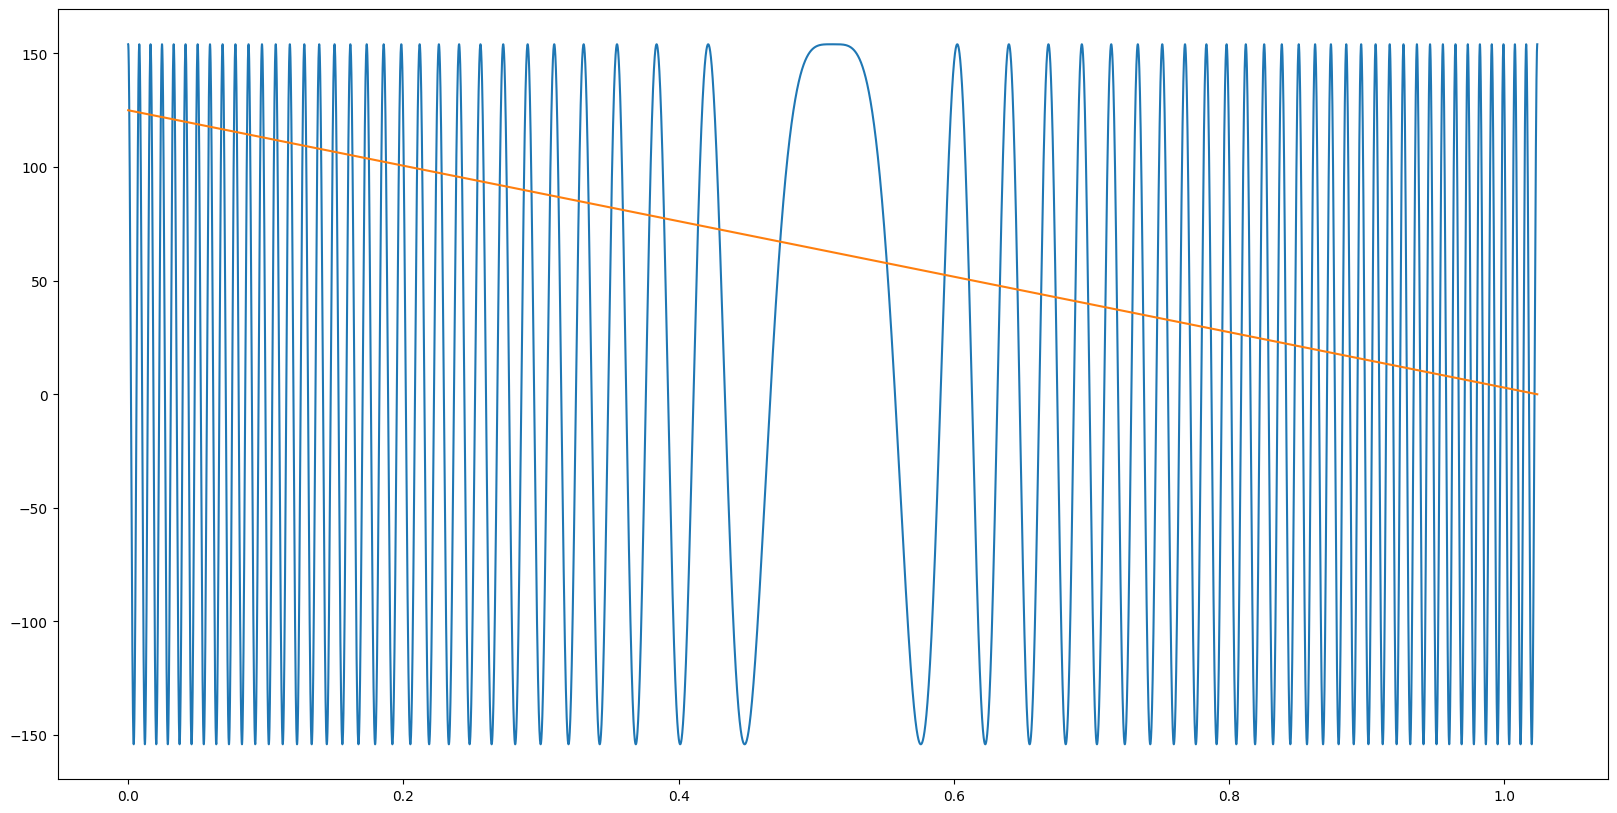

In [44]:
l = LoraModulator(7, 125, 1000)
t, s, f = l.modulate_symbols( [LoraReservedArtifacts.FULL_DOWNCHIRP], True)
plt.figure(figsize=(20,10))
plt.plot(t, 2**14* np.real(s))
plt.plot(t, f)


In [136]:
    # def __init__(self):
    #     self.__modem = None
    #     self.__modem = __import__('modem')
    #     self.__modem = self.__modem.Modem()
    #     self.__modem.set_mode('lora')
    #     self.__modem.set_freq(868.1)
    #     self.__modem.set_pwr(14)
    #     self.__modem.set_sf(12)
    #     self.__modem.set_bw(125)
    #     self.__modem.set_cr(4/5)
    #     self.__modem.set_sync_word(0x12)
    #     self.__modem.set_iq_invert(False)
    #     self.__modem.set_crc(True)
    #     self.__modem.set_preamble(8)
    #     self.__modem.set_header(True)
    #     self.__modem.set_payload_length(0)
    #     self.__modem.set_timeout(1000)
    #     self.__modem.set_sync_word(0x12)
    #     self.__modem.set_iq_invert(False)
    #     self.__modem.set_crc(True)
    #     self.__modem.set_preamble(8)
    #     self.__modem.set_header(True)
    #     self.__modem.set_payload_length(0)
    #     self.__modem.set_timeout(1000)

    # def send(self, data):
    #     self.__modem.send(data)

    # def receive(self):
        # return self.__modem.receive()

    # def close(self):
    #     self.__modem.close()

In [93]:
class LoraDemodulator:
    def __init__(self, spreading_factor, bandwidth, resolution_between_chips):
        # The spreading factor of the LoRa modulation
        self.spreading_factor = spreading_factor
        
        # The bandwidth of the LoRa modulation in KiloHertz
        self.bandwidth = bandwidth

        # The resolution between chips
        self.resolution_between_chips = resolution_between_chips
    
    def generate_full_downchirp(self):
        # Number of discrete levels in the transmitted symbol that eventually will be mapped to a frequency
        chips_number = 2**self.spreading_factor

        # Number of samples per symbol
        samples_per_symbol = int(chips_number * self.resolution_between_chips)

        # Time duration of each symbol
        symbol_duration = (chips_number)/np.abs(self.bandwidth)

        sampling_period = symbol_duration/samples_per_symbol

        # Slope of the downchirp, defined by the bandwidth and the time duration of each symbol
        slope = - (self.bandwidth**2) /chips_number

        y_intercept = (2**self.spreading_factor - 1)*np.abs(self.bandwidth)/(2**self.spreading_factor-1)

        # Frequency evolution of the chirp signal
        symbol_frequency_evolution = []

        symbol_time_axis = np.linspace(0, symbol_duration, samples_per_symbol)
        # Signal
        signal = []

        for i in range(len(symbol_time_axis)):
                
            # Instantaneous frequency of the chirp signal, taking into account the bounds from the bandwidth by using the modulo operator
            instantaneous_frequency = ( y_intercept + slope * symbol_time_axis[i] )

            symbol_frequency_evolution.append(instantaneous_frequency) 

            instantaneous_phase = 1j * 2 * np.pi * instantaneous_frequency * symbol_time_axis[i] 
            coefficient = 1 / (np.sqrt(2**self.spreading_factor)*self.resolution_between_chips)
            signal.append(coefficient * np.exp(instantaneous_phase))

        return symbol_time_axis, symbol_frequency_evolution, signal
        
    def dechirp_symbol(self, signal):
        downchirp_signal = self.generate_full_downchirp()[2]
        dechirped_signal = [signal[i] * downchirp_signal[i] for i in range(len(signal))]
        return dechirped_signal
    
    def demodulate_symbol(self, signal):
        dechirped_signal = self.dechirp_symbol(signal)
        observed_symbol = np.fft.fft(dechirped_signal)
        return observed_symbol

    
    def handle_received_signal(signal):
        pass

In [94]:
l_mod = LoraModulator(7, 125, 1)

l_demod = LoraDemodulator(7, 125, 1)


possible_symbols = [i for i in range(2**7)]

not_quite_good_symbols = []
good_symbols = []
errors = []
for symbol in possible_symbols:
    s = l_mod.modulate_symbols([symbol])[1]
    observed_symbol = np.argmax(l_demod.demodulate_symbol(s))
    if observed_symbol != symbol:
        not_quite_good_symbols.append(symbol)
        errors.append(np.abs(observed_symbol-symbol))
    else:
        good_symbols.append(symbol)




print("simbolos erroneos",not_quite_good_symbols)
print(len(not_quite_good_symbols))
print(np.sum(errors)/len(errors))



simbolos erroneos [0, 1, 2, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
75
4.346666666666667


In [95]:
a = np.linspace(0,1,11)
b = np.linspace(1,2,11)
print(a)
print(b)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2. ]
